In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 # pyyaml нужен для чтения архивов моделей из model zoo
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 5.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=4b4982814bb1b42db1b545bf923f91383fd249d1a73bdb072c16e1bfc282fcad
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True


In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 659kB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=fbde7afa97aa81e907c043d4d3550225d3f7873ae36a7c34a463bfaa14c31f2d
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("neural_gra3", {}, "/content/lables.json", "/content/leavels_learn")

from detectron2.data.datasets import register_coco_instances
register_coco_instances("neural_g31", {}, "/content/labels.json", "/content/leavels_learn")

In [ ]:
rumminet = MetadataCatalog.get("neural_g31")
dataset_dicts = DatasetCatalog.get("neural_g31")

[04/03 15:42:02 d2.data.datasets.coco]: Loaded 36 images in COCO format from /content/labels.json


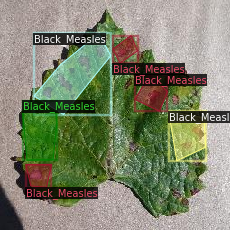

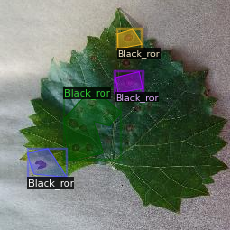

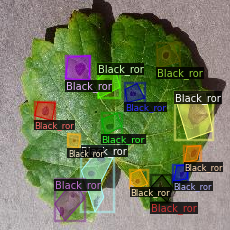

In [ ]:
import random
import cv2

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=rumminet, scale=0.9)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("neural_g31")
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 53  # 3 classes (data, fig, hazelnut)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/03 15:42:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:14, 12.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (54, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (54,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (212, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (212,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model du

[04/03 15:42:59 d2.engine.train_loop]: Starting training from iteration 0
[04/03 15:43:04 d2.utils.events]:  eta: 0:04:02  iter: 19  total_loss: 5.505  loss_cls: 3.975  loss_box_reg: 0.4746  loss_mask: 0.6923  loss_rpn_cls: 0.3388  loss_rpn_loc: 0.05651  time: 0.2468  data_time: 0.0133  lr: 1.9981e-05  max_mem: 1861M
[04/03 15:43:09 d2.utils.events]:  eta: 0:03:55  iter: 39  total_loss: 4.721  loss_cls: 3.243  loss_box_reg: 0.468  loss_mask: 0.6912  loss_rpn_cls: 0.1983  loss_rpn_loc: 0.04792  time: 0.2450  data_time: 0.0059  lr: 3.9961e-05  max_mem: 1908M
[04/03 15:43:14 d2.utils.events]:  eta: 0:03:50  iter: 59  total_loss: 3.258  loss_cls: 1.417  loss_box_reg: 0.5619  loss_mask: 0.6892  loss_rpn_cls: 0.1466  loss_rpn_loc: 0.0526  time: 0.2459  data_time: 0.0055  lr: 5.9941e-05  max_mem: 1992M
[04/03 15:43:19 d2.utils.events]:  eta: 0:03:49  iter: 79  total_loss: 2.433  loss_cls: 1.074  loss_box_reg: 0.6242  loss_mask: 0.6854  loss_rpn_cls: 0.06035  loss_rpn_loc: 0.04756  time: 0.249

In [ ]:
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set the testing threshold for this model
#cfg.DATASETS.TEST = ("neural_grap", )
torch.save(trainer.model, 'model_final.h5')
#predictor = DefaultPredictor(cfg)

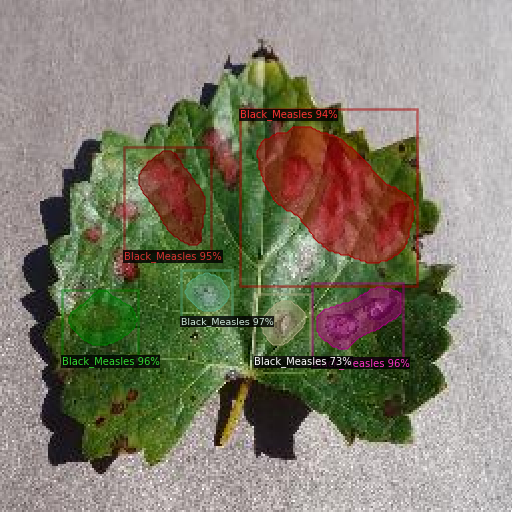

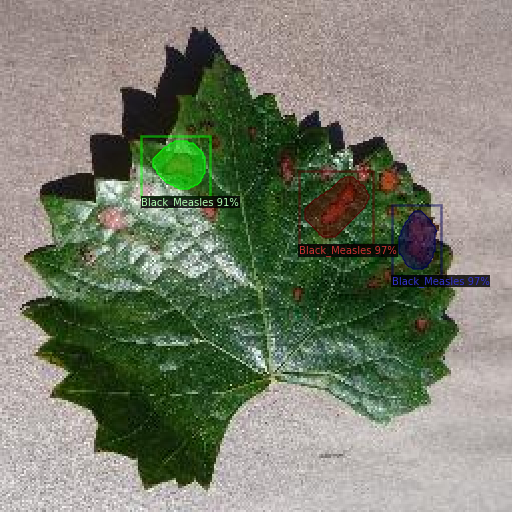

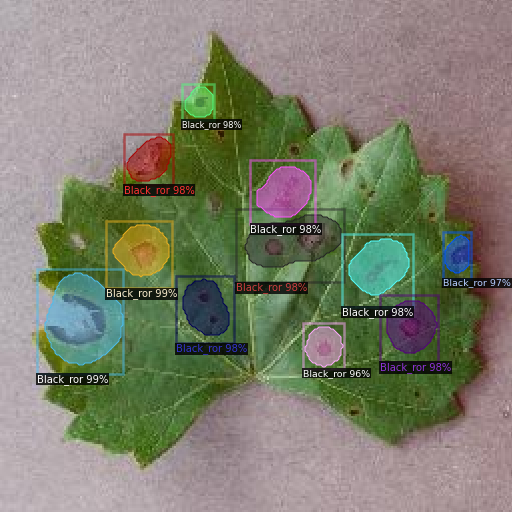

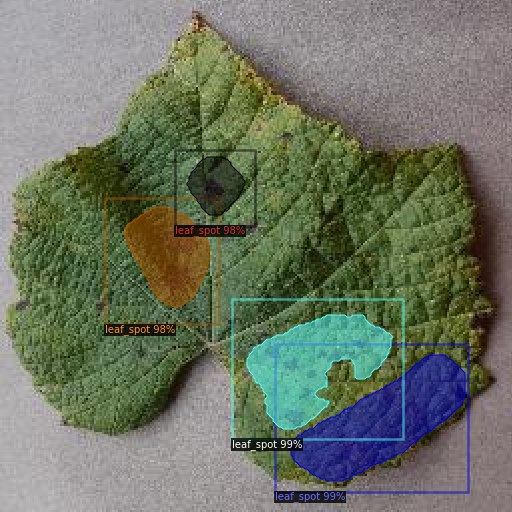

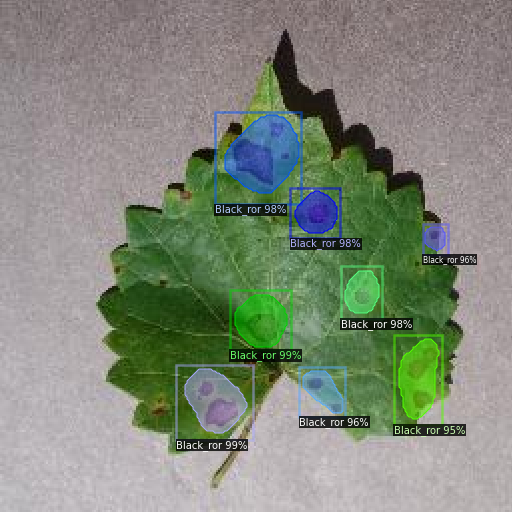

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=rumminet, 
                   scale=2.0, 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

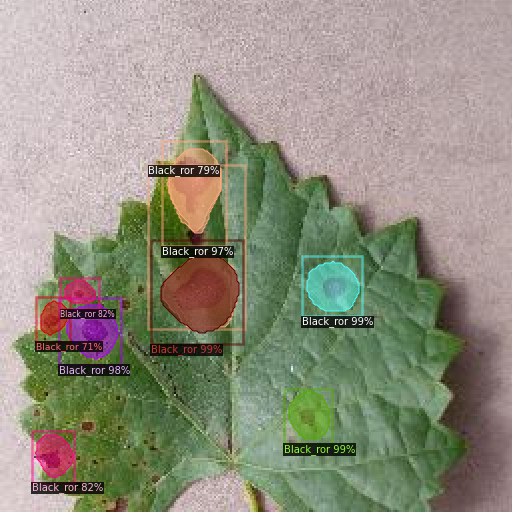

In [ ]:
pat = "/content/Black_ror"
#pat = "/content/Leaf_spot"
#pat = "/content/Black_Measles"
#pat = "/content/Healthi_grap"
im = cv2.imread(os.path.join(pat, random.choice(os.listdir(pat))))
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
              metadata=rumminet, 
              scale=2.0, 
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
print(outputs["instances"].pred_classes) # классы можно посмотреть 
print(outputs["instances"].pred_boxes) #

tensor([2, 1, 1, 1, 1], device='cuda:0')
Boxes(tensor([[ 83.2181,  49.7428, 131.4104, 109.2330],
        [189.9221, 143.1871, 236.5789, 191.1871],
        [ 48.6621,  76.3546,  75.6370, 101.9714],
        [ 41.5632, 170.1244,  67.4245, 193.6479],
        [114.1998, 133.4272, 173.3575, 175.5381]], device='cuda:0'))


In [ ]:
imagetest = plt.imread('/content/drive/MyDrive/split2/101.jpg')
plt.imshow(imagetest)
plt.plot([1,500], [300,1000], linewidth=2)
plt.show()

NameError: ignored